In [1]:
import sys
import pickle
from collections import defaultdict

from matplotlib import colors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from networkx.algorithms.approximation import clique
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR, LinearSVC, LinearSVR
from sklearn.preprocessing import Normalizer
from tqdm.notebook import tqdm

from utils import SBM_Data, Datasets_Data, load_or_calc_and_save, ytrue_to_partition, calc_avranks, RFE, RFE_LOO, OneVsRest_custom, OneHotEncoding_custom

sys.path.append('../../pygkernels')
from pygkernels.scenario import d3_category20

In [2]:
data_hub = SBM_Data()
_, results_modularity_any3, modularity_results = data_hub.load_precalculated()

X, y = data_hub.make_dataset()
X_train, y_train = X[:, :70].reshape(-1, X.shape[2]), y[:, :70].reshape(-1, y.shape[2])
X_val,   y_val   = X[:, 70:].reshape(-1, X.shape[2]), y[:, 70:].reshape(-1, y.shape[2])
X,       y       = X.reshape(-1, X.shape[2]), y.reshape(-1, y.shape[2])

_, y_ari = data_hub.make_dataset(return_clf=False)
ari_train = y_ari[:, :70].reshape(-1, y_ari.shape[2])
ari_val = y_ari[:, 70:].reshape(-1, y_ari.shape[2])

feature_names = data_hub.allowed_features_list

prepare columns: 100%|██████████| 87/87 [00:00<00:00, 680.21it/s]


In [3]:
data_hub.kernel_names.index('SCT')

10

In [4]:
# chosen_feature_names = ['log(n)/k * p_in/p_out', 'avg_sp']
# chosen_feature_names = ['log(n)/k * p_in/p_out', 'median_deg', 'max_clique/(n/k)']
# chosen_feature_names = ['n/k', 'sbm_neighbour_score', 'modularity', 'avg_deg']
chosen_feature_names = ['n', 'k', 'p_in', 'p_out']

chosen_features = []
for chosen_feature in chosen_feature_names:
    chosen_features.append(data_hub.allowed_features_list.index(chosen_feature))
chosen_features

[0, 1, 2, 3]

# Baseline 1: the best measure for all

In [5]:
by_kernel_results = dict(zip(data_hub.kernel_names, np.mean(ari_val, axis=0)))
df = pd.DataFrame(list(by_kernel_results.items()), columns=['measure', 'mean ari'])
df.sort_values('mean ari', ascending=False)

,measure,mean ari
7,logHeat,0.679656
10,SCT,0.676688
11,SCCT,0.673993
6,Heat,0.671092
3,logFor,0.667744
17,logModifPPR,0.659499
19,logHeatPR,0.657415
12,RSP,0.657212
9,logNHeat,0.656543
15,logPPR,0.655025


In [6]:
baseline = list(df.iloc[7])[1]
baseline

0.6796556237904525

# Baseline2: best measure for every column 

In [7]:
by_column_results = defaultdict(list)
for column_name, column_results in results_modularity_any3.items():
    by_kernel_results = defaultdict(list)
    for graph_idx, graph_results in column_results.items():
        for kernel_name, kernel_result in graph_results.items():
            by_kernel_results[kernel_name].append(kernel_result)
    best_measure, best_ari = sorted([(k, np.mean(v)) for k, v in by_kernel_results.items()], key=lambda x: -x[1])[0]
    by_column_results[column_name] = (best_measure, best_ari)

df = pd.DataFrame([(k, v[0], v[1]) for k, v in by_column_results.items()], columns=['column', 'best_measure', 'mean ari'])
upper_bound1 = np.mean(list(df['mean ari']))
upper_bound1

0.6980993595367786

# Upper bound: best measure for every graph

In [8]:
results = list()
for column_name, column_results in results_modularity_any3.items():
    for graph_idx, graph_results in column_results.items():
        graph_best_ari = np.max(list(graph_results.values()))
        results.append(graph_best_ari)

upper_bound2 = np.mean(results)
upper_bound2

0.7363163700296145

# Ours #1 (logRegression)

In [9]:
estimator = OneVsRestClassifier(LogisticRegression())
estimator.fit(X_train[:, chosen_features], y_train)
y_pred = estimator.predict_proba(X_val[:, chosen_features])
ours1 = np.mean(ari_val[range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours1

0.6790508899324308

# Ours #2: choose measure by algo

In [10]:
estimator = OneVsRestClassifier(SVC(probability=True))
estimator.fit(X_train[:, chosen_features], y_train)
y_pred = estimator.predict_proba(X_val[:, chosen_features])

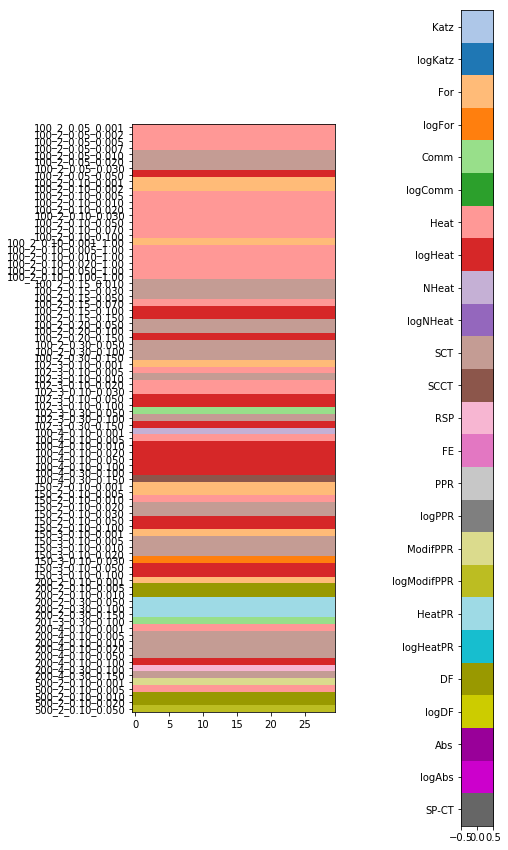

In [11]:
every_graph_choice = np.argmax(y_pred, axis=1).reshape(-1, 30)
every_graph_choice_pic = np.zeros((every_graph_choice.shape[0], 30, 3))

for i in range(every_graph_choice.shape[0]):
    for j in range(every_graph_choice.shape[1]):
        every_graph_choice_pic[i, j] = np.array(colors.hex2color(d3_category20[every_graph_choice[i, j]]))
        
fig, ax = plt.subplots(1, 2, figsize=(8, 15))
ax[0].imshow(every_graph_choice_pic)
ax[0].set_yticks(range(len(data_hub.datasets)))
ax[0].set_yticklabels(data_hub.datasets);

ax[1].imshow(np.array([colors.hex2color(d3_category20[i]) for i in range(25)])[:, None])
ax[1].set_yticks(range(len(data_hub.kernel_names)))
ax[1].set_yticklabels(data_hub.kernel_names);

In [12]:
ours2 = np.mean(ari_val[range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours2

0.6855066458136873

# Ours #3 (filter out kernels)

In [13]:
support_kernels = np.array([False, True, True, True, False, True, True, True, False,
                            False, True, True, True, False, False, False, True, True,
                            True, True, False, False, False, False, True])

In [14]:
estimator = OneVsRestClassifier(SVC(probability=True))
estimator.fit(X_train[:, chosen_features], y_train[:, support_kernels])
y_pred = estimator.predict_proba(X_val[:, chosen_features])
ours3 = np.mean(ari_val[:, support_kernels][range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours3

0.6857906380789496

# Ours #4 (own OneVsRest)

In [15]:
estimator = OneVsRest_custom(SVC(), weight_samples=False)
estimator.fit(X_train[:, chosen_features], y_train[:, support_kernels])
y_pred = estimator.predict(X_val[:, chosen_features])
ours4 = np.mean(ari_val[:, support_kernels][range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours4

0.6531362101716075

# Ours #5 (sample weights)

In [16]:
estimator = OneVsRest_custom(SVC(), weight_samples=True)
estimator.fit(X_train[:, chosen_features], y_train[:, support_kernels])
y_pred = estimator.predict(X_val[:, chosen_features])
ours5 = np.mean(ari_val[:, support_kernels][range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours5

0.6496285141761796

# Ours #6 (SVR)

In [17]:
estimator = OneVsRest_custom(SVR(), weight_samples=False)
estimator.fit(X_train[:, chosen_features], ari_train[:, support_kernels])
y_pred = estimator.predict(X_val[:, chosen_features])
ours6 = np.mean(ari_val[:, support_kernels][range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours6

0.6890979304642655

# Ours # 7 (SVR, sample weights)

In [18]:
estimator = OneVsRest_custom(SVR(), weight_samples=True)
estimator.fit(X_train[:, chosen_features], ari_train[:, support_kernels])
y_pred = estimator.predict(X_val[:, chosen_features])
ours7 = np.mean(ari_val[:, support_kernels][range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours7

0.6893947742169105

# Ours #8 (SVR, sample weights, normalized to max)

In [19]:
estimator = OneVsRest_custom(SVR(), weight_samples=True)
estimator.fit(X_train[:, chosen_features], ari_train[:, support_kernels] / np.max(ari_train[:, support_kernels], axis=1, keepdims=1))
y_pred = estimator.predict(X_val[:, chosen_features])
ours8 = np.mean(ari_val[:, support_kernels][range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours8

0.6895419913877225

# Ours #9 (RandomForestClassifier, sample_weights)

In [20]:
estimator = RandomForestClassifier()
estimator.fit(X_train[:, chosen_features], y_train[:, support_kernels])
y_pred = estimator.predict(X_val[:, chosen_features])
ours9 = np.mean(ari_val[:, support_kernels][range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours9

0.6569564316624972

# Ours #10 (RandomForestRegressor, sample_weights)

In [21]:
estimator = RandomForestRegressor()
estimator.fit(X_train[:, chosen_features], ari_train[:, support_kernels])
y_pred = estimator.predict(X_val[:, chosen_features])
ours10 = np.mean(ari_val[:, support_kernels][range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours10

0.6961927761164839

# Ours #11 (KNeighborsClassifier)

In [22]:
estimator = OneVsRest_custom(KNeighborsClassifier(n_neighbors=5), weight_samples=False)
estimator.fit(X_train[:, chosen_features], y_train[:, support_kernels])
y_pred = estimator.predict(X_val[:, chosen_features])
ours11 = np.mean(ari_val[:, support_kernels][range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours11

0.6691547521394205

# Ours #12 (KNeighborsRegressor)

In [23]:
estimator = OneVsRest_custom(KNeighborsRegressor(n_neighbors=5), weight_samples=False)
estimator.fit(X_train[:, chosen_features], ari_train[:, support_kernels])
y_pred = estimator.predict(X_val[:, chosen_features])
ours12 = np.mean(ari_val[:, support_kernels][range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours12

0.6869338735658225

# Ours #13 (LinearSVC)

In [24]:
estimator = OneVsRest_custom(LinearSVC(max_iter=10000), weight_samples=True)
estimator.fit(X_train[:, chosen_features], y_train[:, support_kernels])
y_pred = estimator.predict(X_val[:, chosen_features])
ours13 = np.mean(ari_val[:, support_kernels][range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours13

0.6494286369714138

# Ours #14 (LinearSVR)

In [25]:
estimator = OneVsRest_custom(LinearSVR(max_iter=10000), weight_samples=True)
estimator.fit(X_train[:, chosen_features], ari_train[:, support_kernels])
y_pred = estimator.predict(X_val[:, chosen_features])
ours14 = np.mean(ari_val[:, support_kernels][range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours14

0.6836266256934973

# Ours #15 (OneHotEncoding(SVR))

In [26]:
estimator = OneHotEncoding_custom(SVR(), weight_samples=False)
estimator.fit(X_train[:, chosen_features], ari_train[:, support_kernels])
y_pred = estimator.predict(X_val[:, chosen_features])
ours15 = np.mean(ari_val[:, support_kernels][range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours15

0.6894664243418729

# Ours #16 (OneHotEncoding(SVR), sample_weights)

In [27]:
estimator = OneHotEncoding_custom(SVR(), weight_samples=True)
estimator.fit(X_train[:, chosen_features], ari_train[:, support_kernels])
y_pred = estimator.predict(X_val[:, chosen_features])
ours16 = np.mean(ari_val[:, support_kernels][range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours16

0.6888947560139153

# Summary

In [28]:
df = pd.DataFrame([
    (-1,'BASELINE 1 - one measure for all', baseline),
    (1, 'OneVsRest(logRegression)', ours1),
    (2, 'OneVsRest(SVC)', ours2),
    (3, 'OneVsRest(SVC), filter kernels', ours3),
    (4, 'separate(SVC), filter kernels', ours4),
    (5, 'separate(SVC), filter kernels, weight samples', ours5),
    (6, 'separate(SVR), filter kernels', ours6),
    (7, 'separate(SVR), filter kernels, weight samples', ours7),
    (8, 'separate(SVR), filter kernels, weight samples, normalized', ours8),
    (9, 'RandomForestClassifier, filter kernels', ours9),
    (10, 'RandomForestRegressor, filter kernels', ours10),
    (11, 'separate(KNeighborsClassifier), filter kernels', ours11),
    (12, 'separate(KNeighborsRegressor), filter kernels', ours12),
    (13, 'separate(LinearSVC), filter kernels, weight samples', ours13),
    (14, 'separate(LinearSVR), filter kernels, weight samples', ours14),
    (15, 'onehotencoding(SVR), filter kernels', ours15),
    (16, 'onehotencoding(SVR), filter kernels, weight samples', ours16),
    (-1, 'BASELINE 2 - opt. measure for every column', upper_bound1),
    (-1, 'UPPER BOUND – opt. measure for every graph', upper_bound2)
], columns=['exp_no', 'method', 'ari'])
df.sort_values(by='ari', ascending=False)

,exp_no,method,ari
18,-1,UPPER BOUND – opt. measure for every graph,0.736316
17,-1,BASELINE 2 - opt. measure for every column,0.698099
10,10,"RandomForestRegressor, filter kernels",0.696193
8,8,"separate(SVR), filter kernels, weight samples,...",0.689542
15,15,"onehotencoding(SVR), filter kernels",0.689466
7,7,"separate(SVR), filter kernels, weight samples",0.689395
6,6,"separate(SVR), filter kernels",0.689098
16,16,"onehotencoding(SVR), filter kernels, weight sa...",0.688895
12,12,"separate(KNeighborsRegressor), filter kernels",0.686934
3,3,"OneVsRest(SVC), filter kernels",0.685791
